In [26]:
# Step 1: Install necessary libraries
!pip install pandas scikit-learn xgboost

# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 3: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 4: Load dataset (with encoding fallback)
file_path = '/content/drive/MyDrive/sales_data.csv'

try:
    df = pd.read_csv(file_path, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(file_path, encoding='ISO-8859-1')  # fallback if utf-8 fails

# Step 5: Display first few rows (optional)
print("Sample Data:")
print(df.head())

# Step 6: Preprocess data
# Replace 'date' with the actual column name in your CSV file
date_column_name = 'ORDERDATE'  # Replace with your actual date column name
df[date_column_name] = pd.to_datetime(df[date_column_name], errors='coerce')
# Check if 'store_open' column exists before filtering
if 'store_open' in df.columns:
    df = df[df['store_open'] == 1]  # Keep only rows where store is open
else:
    print("Warning: 'store_open' column not found. Skipping filtering.")
df = df.dropna(subset=[date_column_name])  # Drop invalid dates

# Feature engineering based on labels
df['day_of_week'] = df[date_column_name].dt.dayofweek
df['month'] = df[date_column_name].dt.month
# Convert categorical variables using one-hot encoding
# Check if columns exist before one-hot encoding
categorical_cols = ['store_type', 'holiday']
existing_categorical_cols = [col for col in categorical_cols if col in df.columns]
if existing_categorical_cols:
    df = pd.get_dummies(df, columns=existing_categorical_cols, drop_first=True)
else:
    print("Warning: Categorical columns not found. Skipping one-hot encoding.")

# Step 7: Prepare training data
X = df.drop(columns=['SALES', 'ORDERDATE'])  # Changed 'sales' to 'SALES' and 'date' to 'ORDERDATE'
y = df['SALES']  # Changed 'sales' to 'SALES'

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Scale features
scaler = StandardScaler()
# Select numerical features from X_train and X_test
X_train_num = X_train.select_dtypes(include=np.number) # Get numerical features for scaling
X_test_num = X_test.select_dtypes(include=np.number)  # Get numerical features for scaling
X_train_scaled = scaler.fit_transform(X_train_num)  # Scale only numerical features
X_test_scaled = scaler.transform(X_test_num)  # Scale only numerical features


# Step 9: Train and evaluate models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    print(f"\n{name} Performance:")
    print(f"MAE: {mean_absolute_error(y_test, preds):.2f}")
    # Calculate RMSE without the 'squared' parameter (for older scikit-learn versions)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2_score(y_test, preds):.2f}")
# Step 9: Train and evaluate models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    print(f"\n{name} Performance:")
    print(f"MAE: {mean_absolute_error(y_test, preds):.2f}")
    # Calculate RMSE without the 'squared' parameter (for older scikit-learn versions)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2_score(y_test, preds):.2f}")

    # Step 10: Retrain best model (XGBoost) on all data
final_model = XGBRegressor(n_estimators=200, random_state=42)
# Select numerical features from X
X_num = X.select_dtypes(include=np.number)
# Scale and fit the model with numerical features only
final_model.fit(scaler.fit_transform(X_num), y)

# Step 11: Forecast next 30 days
future_dates = pd.date_range(start=df[date_column_name].max() + pd.Timedelta(days=1), periods=30)
# Create base DataFrame for future
future_df = pd.DataFrame({'date': future_dates})  # 'date' column is created here
future_df['day_of_week'] = future_df['date'].dt.dayofweek
future_df['month'] = future_df['date'].dt.month

# Reindex future_df to have the same columns as X_num and fill NaN with 0
# Include 'date' in the columns to keep it
future_df = future_df.reindex(columns=['date'] + list(X_num.columns), fill_value=0)

# Ensure correct column order for prediction
future_features = future_df[X_num.columns]

# Scale and predict
future_scaled = scaler.transform(future_features)
future_df['predicted_sales'] = final_model.predict(future_scaled)

# Step 12: Display forecast
print("\nSales Forecast for the Next 30 Days:")
print(future_df[['date', 'predicted_sales']])  # Now 'date' should be available


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sample Data:
   ORDERNUMBER  QUANTITYORDERED  PRICEEACH  ORDERLINENUMBER    SALES  \
0        10107               30      95.70                2  2871.00   
1        10121               34      81.35                5  2765.90   
2        10134               41      94.74                2  3884.34   
3        10145               45      83.26                6  3746.70   
4        10159               49     100.00               14  5205.27   

         ORDERDATE   STATUS  QTR_ID  MONTH_ID  YEAR_ID  ...  \
0   2/24/2003 0:00  Shipped       1         2     2003  ...   
1    5/7/2003 0:00  Shipped       2         5     2003  ...   
2    7/1/2003 0:00  Shipped       3         7     2003  ...   
3   8/25/2003 0:00  Shipped       3         8     2003  ...   
4  10/10/2003 0:00  Shipped       4        10     2003  ...   

                    ADDRESSLINE1  ADDRESSLINE2

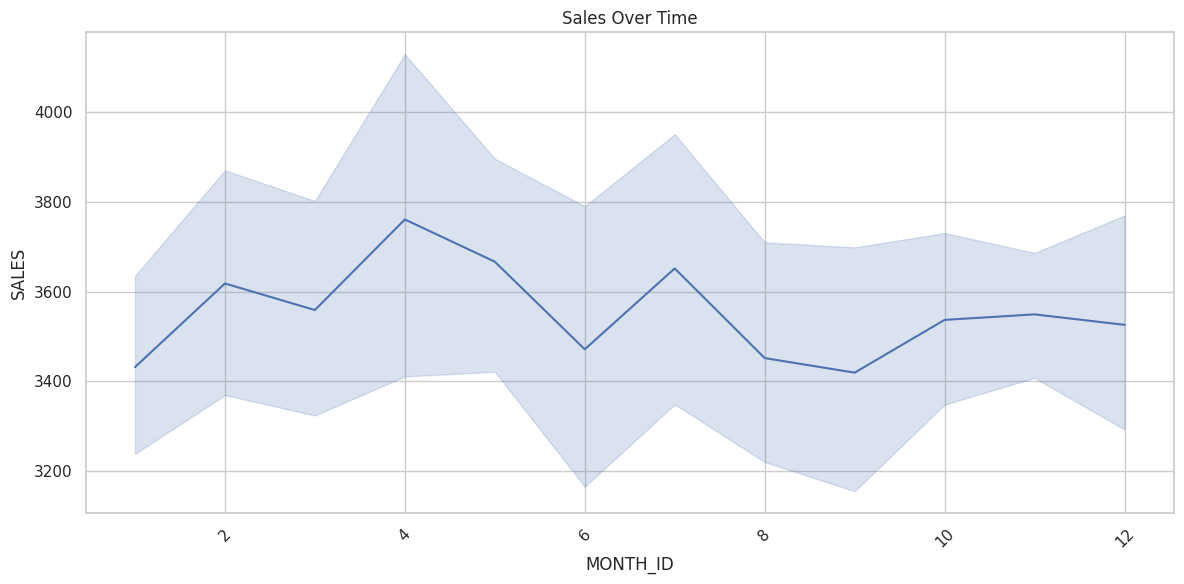

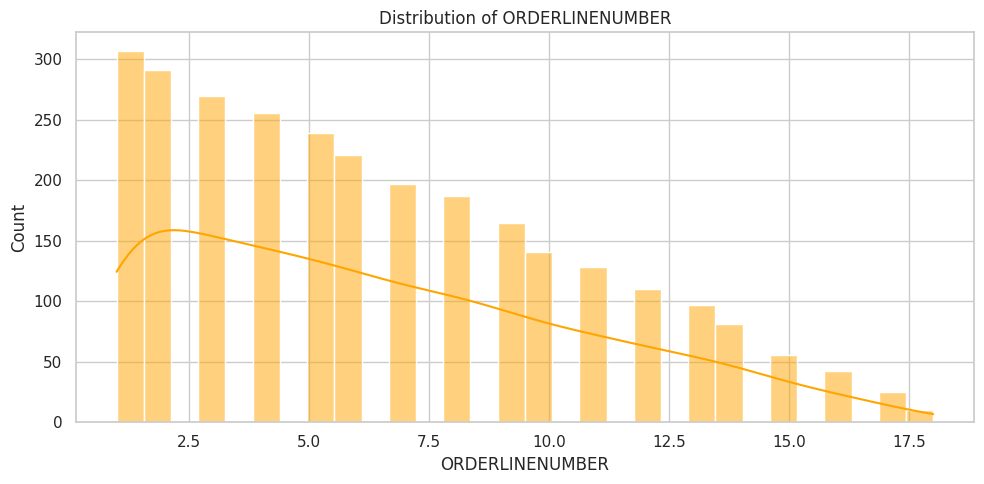

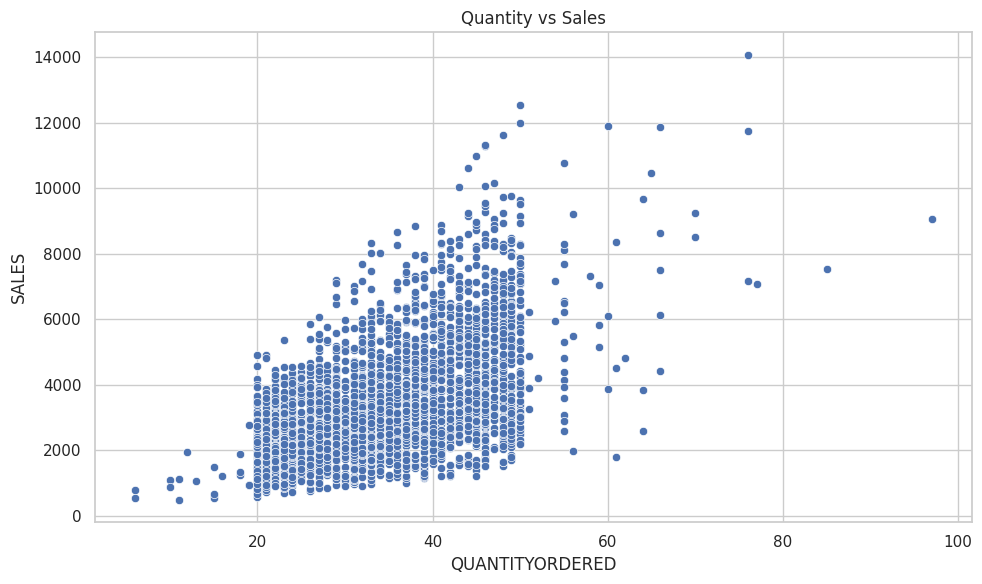

In [15]:
# Install plotting libraries if not already installed
!pip install matplotlib seaborn

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: Set Seaborn style
sns.set(style="whitegrid")

# Check if necessary columns exist
required_columns = ['SALES', 'ORDERLINENUMBER', 'QUANTITYORDERED']
missing = [col for col in required_columns if col not in df.columns]
if missing:
    print(f"Missing columns in data: {missing}")
else:
    # Plot 1: Sales over Time
    # Assuming 'MONTH_ID' is the correct column for the x-axis
    plt.figure(figsize=(12, 6))
    # Sort by 'MONTH_ID' if it exists, otherwise use the DataFrame's index
    sort_column = 'MONTH_ID' if 'MONTH_ID' in df.columns else df.index
    sns.lineplot(data=df.sort_values(by=sort_column), x='MONTH_ID', y='SALES')
    plt.title('Sales Over Time')
    plt.xlabel('MONTH_ID')
    plt.ylabel('SALES')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot 2: Distribution of ORDERLINENUMBER
    plt.figure(figsize=(10, 5))
    sns.histplot(df['ORDERLINENUMBER'], bins=30, kde=True, color='orange')
    plt.title('Distribution of ORDERLINENUMBER')
    plt.xlabel('ORDERLINENUMBER')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

    # Plot 3: Quantity vs Sales Scatter Plot
    plt.figure(figsize=(10, 6))
    # Assuming 'QUANTITYORDERED' is the intended column for x-axis
    sns.scatterplot(data=df, x='QUANTITYORDERED', y='SALES', )
    plt.title('Quantity vs Sales')
    plt.xlabel('QUANTITYORDERED')
    plt.ylabel('SALES')
    plt.tight_layout()
    plt.show()


Sales Forecast for the Next 30 Days:
         date  predicted_sales
0  2005-06-01       520.527100
1  2005-06-02       521.001892
2  2005-06-03       509.584930
3  2005-06-04       523.174011
4  2005-06-05       534.614563
5  2005-06-06       520.613037
6  2005-06-07       512.071533
7  2005-06-08       520.527100
8  2005-06-09       521.001892
9  2005-06-10       509.584930
10 2005-06-11       523.174011
11 2005-06-12       534.614563
12 2005-06-13       520.613037
13 2005-06-14       512.071533
14 2005-06-15       520.527100
15 2005-06-16       521.001892
16 2005-06-17       509.584930
17 2005-06-18       523.174011
18 2005-06-19       534.614563
19 2005-06-20       520.613037
20 2005-06-21       512.071533
21 2005-06-22       520.527100
22 2005-06-23       521.001892
23 2005-06-24       509.584930
24 2005-06-25       523.174011
25 2005-06-26       534.614563
26 2005-06-27       520.613037
27 2005-06-28       512.071533
28 2005-06-29       520.527100
29 2005-06-30       521.001892


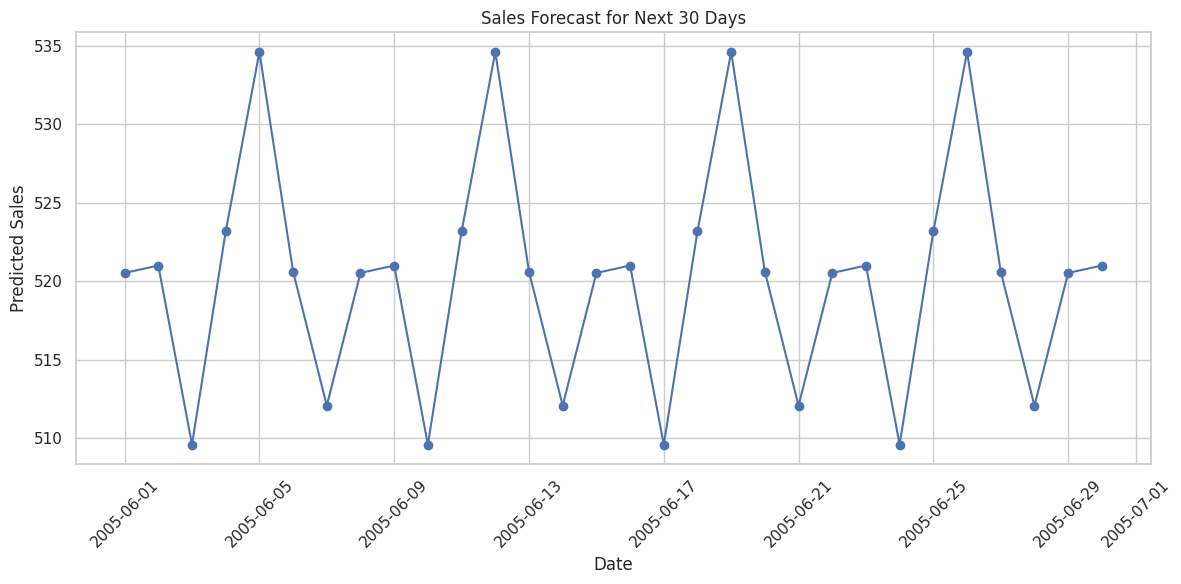

In [27]:
# Install plotting libraries if not already installed
!pip install matplotlib seaborn

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# ... (Your existing code for forecasting) ...

# Step 12: Display forecast AND GRAPH
print("\nSales Forecast for the Next 30 Days:")
print(future_df[['date', 'predicted_sales']])  # Now 'date' should be available


# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(future_df['date'], future_df['predicted_sales'], marker='o', linestyle='-')
plt.title('Sales Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Sales')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()